# Topic 3. Algebraic data types

## 3.4 Isomorphisms

Intuitively, we say that two types $A$ and $B$ are isomorphic, $A \cong B$,  if they represent the same information. More specifically, if we regard types as _sets of values_, then we can say that two types are isomorphic if their values can be put in a one-to-one correspondence, i.e. if we can establish a _bijection_ between their corresponding sets of values.

Thus, to establish an isomorphism betwween two types $A$ and $B$, we have to implement two functions $from$ and $to$, and prove that these functions are mutual inverses. These requirements can be implemented through the following _template_:

In [1]:
trait Isomorphic[A, B]:
    
    def from(a: A): B
    
    def to(b: B): A
    
    // equality 
    
    def equalA(a1: A, a2: A): Boolean = 
        a1 == a2
    
    def equalB(b1: B, b2: B): Boolean =
        b1 == b2
    
    // Bijection laws
    
    def law1(a: A): Boolean = 
        equalA(to(from(a)), a)
    
    def law2(b: B): Boolean = 
        equalB(from(to(b)), b)

defined trait Isomorphic

> ![image.png](../images/scala3api3.jpg) Technically, the `Isomorphism` trait is an example of [type class](https://docs.scala-lang.org/scala3/book/ca-type-classes.html), a functional design pattern and technique which is beyond the scope of this course.

For instance, the isomorphism $Boolean * 1 \cong Boolean$ is witnessed by the following functions: 

In [2]:
object Iso1 extends Isomorphic[Boolean, (Boolean, Unit)]:
    
    def from(b: Boolean): (Boolean, Unit) = 
        (b, ())
    
    def to(p: (Boolean, Unit)): Boolean = 
        p._1

defined object Iso1

which satisfy:
- `from(to(b))=b`, for all `b: (Boolean, Unit)`, and 
- `to(from(b))=b` for all `b: Boolean`.

In order to make these tests, we will employ the unit testing framework `scalatest`: 

In [3]:
import $ivy.`org.scalatest::scalatest:3.2.16`
import org.scalatest.{Filter => _, _}, flatspec._, matchers._

import $ivy.$                                

import org.scalatest.{Filter => _, _}, flatspec._, matchers._


together with the following testing class:

In [11]:
class TestIso[A, B](iso: Isomorphic[A, B])(a: A*)(b: B*)  extends AnyFlatSpec with should.Matchers:
    import iso._

    "law1" should "hold" in:
        a.forall(law1) should be(true)

    "law2" should "hold" in:
        b.forall(law2) should be(true)

defined class TestIso

Indeed:

In [41]:
run(TestIso(Iso1)
           (false, true)
           ((false, ()), (true, ())))

cell11$Helper$TestIso:
law1
- should hold
law2
- should hold


## High-school algebra equalities

The correspondence between algebraic data types and arithmetic goes is striking, since the familiar laws of hight-school algebra holds for ADTs as well:

$$ 
\begin{array}{lrcl}
1) & X+0 & = & X \\
2) & X+Y & = & Y+X \\
3) & X+(Y+Z) & = & (X+Y)+Z \\
4) & X*0 & = & 0 \\
4) & X*1 & = & X \\
6) & X*Y & = & Y*X \\
7) & X*(Y*Z) & = & (X*Y)*Z \\
8) & X*(Y+Z) & = & X*Y+X*Z \\
9) & X^0 & = & 1 \\
10) & 1^X & = & 1 \\
11) & X^1 & = & X \\
12) & Z^{X+Y} & = &  Z^X * Z^Y \\
13) & (Y*Z)^X & = & Y^X*Z^X \\
14) & (Z^Y)^X & = & Z^{X*Y} \\
\end{array}
$$



In correspondence with these equalities, we can establish the following isomorphisms:

$$ 
\begin{array}{rcl}
Either[X,Nothing] & \cong & X \\
Either[X,Y] & \cong & Either[Y,X] \\
Either[X,Either[Y,Z]] & \cong & Either[Either[X,Y],Z] \\
(X,Nothing) & \cong & Nothing \\
(X,Unit) & \cong & X \\
(X,Y) & \cong & (Y,X) \\
(X,(Y,Z)) & \cong & ((X,Y),Z) \\
(X,Either[Y,Z]) & \cong & Either[(X,Y),(X,Z)] \\
Nothing  \Rightarrow X & \cong & Unit \\
X \Rightarrow Unit & \cong & Unit \\
Unit \Rightarrow X & \cong & X \\
Either[X,Y] \Rightarrow Z & \cong & (X \Rightarrow Z, Y \Rightarrow Z) \\
X \Rightarrow (Y,Z) & \cong & (X \Rightarrow Y, X \Rightarrow Z) \\
X \Rightarrow (Y \Rightarrow Z) & \cong & (X,Y) \Rightarrow Z \\
\end{array}
$$



## Type-driven development

In order to prove isomorphisms, we will benefit from paying careful attention to the table of constructors and destructors of ADTs.

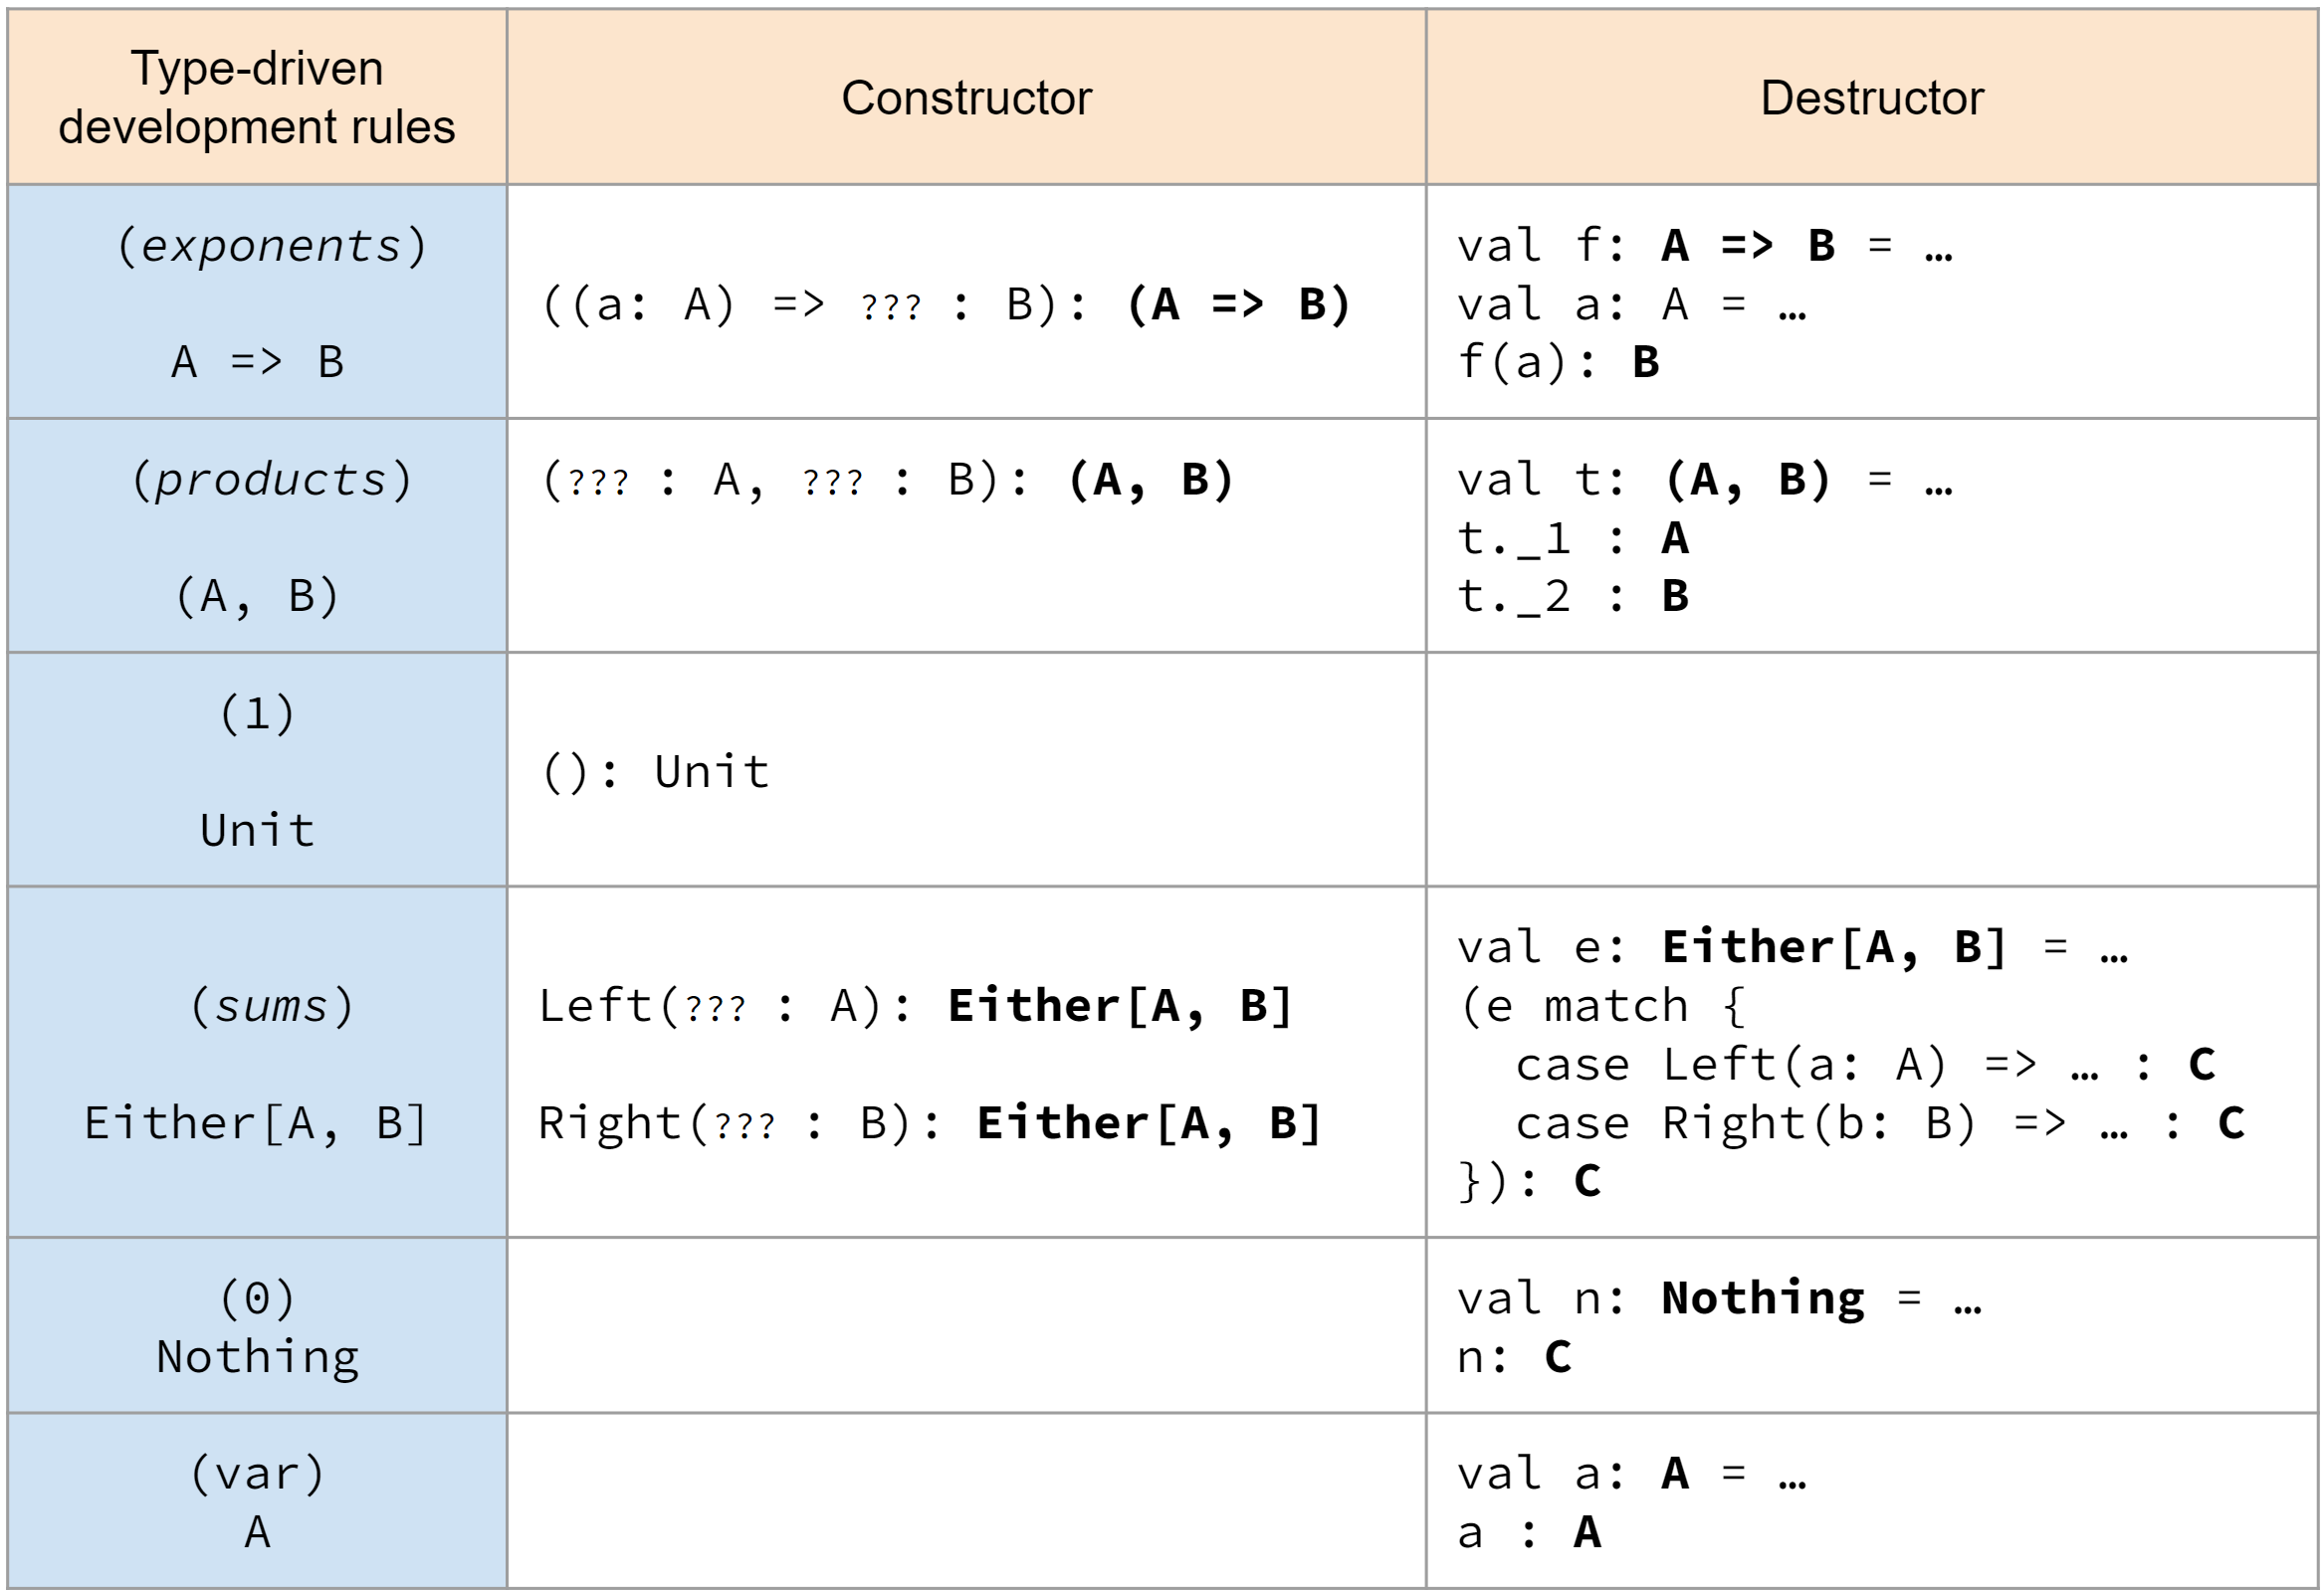

Essentially, these constructors and destructors tell us how we can create values of a given algebraic data type, and which information we can extract from them. The signatures of the `from` and `to` functions of some isomorphism tell us which data types we have to create (the output of the functions) and which information is available to create those results (the input value). Besides the constructors and destructors of the different ADTs, we also add to this table a new trivial rule (_var_), which allows us to observe a value of type $A$ if a variable of that type is already available. 

The implementation of the `from` and `to` functions of an isomorphism will be guided by a _type-driven development_ method:
* The method starts with an empty implementation consisting only of a _hole_ whose type is the function's result. Holes are represented by the Scala expression `??? : A`, with `A` being the type of the hole.
* The method is structured in a number of steps, and proceeds by successively refining the program _holes_. A hole is refined by applying a constructor or destructor from the table. Refining a hole may create new holes. In any case, the code resulting from each step should compile without any issues.
* If the hole's type is a function, product or sum type, then we can apply the corresponding constructor. The application of a constructor invariable involves creating new holes (except in the case of the `Unit` constructor).
* If the hole is `Nothing` or a variable `A`, we have to apply a destructor that allows us to infer that type of value. Here, we will pay special attention to all the variables that are available in the hole's scope to be refined. The only destructor that may create new holes is function application.
* At any given time, we may find several candidate holes and several constructors or destructors available to proceed. In the case of constructors, this may only occur for the _sum_ type: in that case, we may choose between the `Left` and `Right` constructors.
* The method may end successfully, meaning there are no holes left unimplemented. Otherwise, the implementation may end unsuccessfully, meaning the signature can't be implemented, i.e. there are no functions of that type. This may happen because we exhausted all the alternatives to refine a given hole. Alternatively, this may also happen because we entered into a loop, applying again and again the same constructors and destructors without making any real progress toward the solution.
* In applying the method, it's essential to ascribe types to each hole and annotate the available variables with their corresponding types. Remember, types guide the development process. However, once we are done, we can benefit from cleaning up the resulting implementation.

## $$ 
\begin{array}{rcl}
Either[X,Y] \Rightarrow Z & \cong & (X \Rightarrow Z, Y \Rightarrow Z)
\end{array}
$$

Before delving into the implementation of this isomorphism, note that it holds since the number of values of both types is the same. The following calculation demonstrates it:

$|Either[X, Y] => Z| = \\
\,\,|Z|^{Either[X, Y]} = \\
\,\,|Z|^{|X|+|Y|} = \\
\,\,|Z|^{|X|}*|Z|^{|Y|} = \\
\,\,|X => Z|*|Y => Z| = \\
\,\,|(X => Z, Y => Z)|$

Let's illustrate the type-driven development method with the implementation of the isomorphism:

In [ ]:
class Iso[X, Y, Z] extends Isomorphic[Either[X, Y] => Z, (X => Z, Y => Z)]:
    
    def from(a: Either[X,Y] => Z): (X => Z, Y => Z) = 
        ??? : (X => Z, Y => Z)
    
    def to(a: (X => Z, Y => Z)): Either[X, Y] => Z = 
        ???


#### from

Let's start with the `from` function and create an implementation consisting of a single hole of the result type:

In [ ]:
// STEP 1: INIT

// Hole 1: (X => Z, Y => Z)

def from[X, Y, Z](a: Either[X,Y] => Z): (X => Z, Y => Z) = 
    ??? : (X => Z, Y => Z)

Since the type's hole is a product type, we can advance to the next step by applying the corresponding constructor. 

In [ ]:
// STEP 2: CONSTRUCTOR (PRODUCT)

// Hole 1: X => Z
// Hole 2: Y => Z

def from[X, Y, Z](a: Either[X,Y] => Z): (X => Z, Y => Z) = 
    (??? : X => Z, 
     ??? : Y => Z)

By applying the product constructor, two additional holes are created of function type. We proceed by implementing the scheme of the corresponding lambda expressions.

In [ ]:
// STEP 3: CONSTRUCTOR (FUNCTION)

// Hole 1: Z
// Available variables: a, x

// Hole 2: Z
// Available variables: a, y

def from[X, Y, Z](a: Either[X,Y] => Z): (X => Z, Y => Z) = 
    ((x : X) => ??? : Z, 
     (y : Y) => ??? : Z)

Now, the holes are of type `Z`, an arbitrary type parameter for which we have no constructor. Hence, our only chance to get an expression of this type is by extracting information from the available variables in the scope of the different holes. In the case of the first hole, the available variables are `a` and `x`; in the second hole, available variables are `y` and `a`. The only way to obtain a value of type `Z` is by applying function `a`. We don't know yet how to obtain the input argument for this function, but we proceed nonetheless.

In [ ]:
// STEP 4: DESTRUCTOR (FUNCTION)

// Hole 1: Either[X, Y]
// Hole 2: Either[X, Y]

def from[X, Y, Z](a: Either[X,Y] => Z): (X => Z, Y => Z) = 
    ((x : X) => a(??? : Either[X, Y]) : Z, 
     (y : Y) => a(??? : Either[X, Y]) : Z)

Function application reveals a new hole of sum type. Here we can apply the constructors of sums, `Left` and `Right`, but which of them? Given the information available for each hole, it's wise to choose `Left` for the first hole, and `Right` for the second one. 

In [ ]:
// STEP 5: CONSTRUCTOR (SUM)

// Hole 1: X
// Available variables: a, x

// Hole 2: Y
// Available variables: a, y

def from[X, Y, Z](a: Either[X,Y] => Z): (X => Z, Y => Z) = 
    ((x : X) => a(Left(??? : X) : Either[X, Y]) : Z, 
     (y : Y) => a(Right(??? : Y): Either[X, Y]) : Z)

Last, the new holes created through the sum constructors are of types `X` and `Y`, respectively. But these are easy to refine because in their program scope we find variables of exactly those types (we thus apply the _var_ observer). 

In [ ]:
// STEP 6: DESTRUCTOR (VAR)

def from[X, Y, Z](a: Either[X,Y] => Z): (X => Z, Y => Z) = 
    ((x : X) => a(Left(x : X) : Either[X, Y]) : Z, 
     (y : Y) => a(Right(y : Y): Either[X, Y]) : Z)

As a final step, we can simplify the implementation by removing all the type annotations and ascriptions that guided the development process.

In [ ]:
// STEP 7: CLEAN-UP

def from[X, Y, Z](a: Either[X,Y] => Z): (X => Z, Y => Z) = 
    (x => a(Left(x)), 
     y => a(Right(y)))

Of course, an experienced programmer may have reached this program without such a systematic method, simply by carefully inspecting the available input and the desired output.

#### to

Let's try implementing the `to` function. As always, we start by creating a single hole whose type must be the output type.

In [ ]:
// STEP 1: INIT

// Hole 1: Either[X, Y] => Z

def to[X, Y, Z](a: (X => Z, Y => Z)): Either[X,Y] => Z = 
    ??? : (Either[X, Y] => Z)

This step is easy, since the only way to refine this hole is by implementing the corresponding lambda expression.

In [ ]:
// STEP 2: CONSTRUCTOR (FUNCTION)

// Hole 1: Z
// Available variables: a, e

def to[X, Y, Z](a: (X => Z, Y => Z)): Either[X,Y] => Z = 
    (e: Either[X, Y]) => ??? : Z

The hole is of type `Z`, a type parameter, so we have to extract information from the available variables in order to write an expression of this type: variable `a: (X => Z, Y => Z)` and `e: Either[X, Y]`. There are a number of alternatives here: we may extract the first component of the tuple, we may extract its second component or we may apply pattern matching. Clearly, we can only obtain a value of type `Z` through the functions `X => Z` or `Y => Z`. And we will only be able to extract `Z` from these functions if we find an `X` or `Y`. Now, the only way to find one of these values is through variable `e`, though we don't know which value this variable holds. So, we apply pattern matching.

In [ ]:
// STEP 3: DESTRUCTOR (SUM)

// Hole 1: Z
// Available variables: a, e, x

// Hole 2: Z
// Available variables: a, e, y

def to[X, Y, Z](a: (X => Z, Y => Z)): Either[X,Y] => Z = 
    (e: Either[X, Y]) => e match
        case Left(x: X) => ??? : Z
        case Right(y: Y) => ??? : Z

Now we have two holes instead of one, but the situation has improved since we have more information for each of them: for the first one, we have an `x: X` available, and for the second one a `y: Y`. So, in order to proceed towards our goal of refining the `Z` holes, we choose for the first one to extract the first component of the tuple `a`, and for the second hole the second component. 

In [ ]:
// STEP 4: DESTRUCTOR (PRODUCT)

// Hole 1: Z
// Available variables: a, e, x

// Hole 2: Z
// Available variables: a, e, y

def to[X, Y, Z](a: (X => Z, Y => Z)): Either[X,Y] => Z = 
    case Left(x: X) => 
        val f: X => Z = a._1
        ??? : Z
    case Right(y: Y) => 
        val g: Y => Z = a._2
        ??? : Z

Once we have direct access to the functions that allow us to obtain `Z` values, we apply them.

In [ ]:
// STEP 5: DESTRUCTOR (FUNCTION)

// Hole 1: x
// Available variables: a, e, x, f

// Hole 2: y
// Available variables: a, e, y, f

def to[X, Y, Z](a: (X => Z, Y => Z)): Either[X,Y] => Z = 
    case Left(x: X) => 
        val f: X => Z = a._1
        f(??? : X) : Z
    case Right(y: Y) => 
        val f: Y => Z = a._2
        f(??? : Y) : Z

Finally, variables of the required types are available within the program's scope.

In [ ]:
// STEP 6: DESTRUCTOR (VAR)

def to[X, Y, Z](a: (X => Z, Y => Z)): Either[X,Y] => Z = 
    case Left(x: X) => 
        val f: X => Z = a._1
        f(x : X) : Z
    case Right(y: Y) => 
        val f: Y => Z = a._2
        f(y : Y) : Z

After cleaning-up the resulting function we obtain the following implementation.

In [ ]:
// STEP 7: CLEAN-UP

def to[X, Y, Z](a: (X => Z, Y => Z)): Either[X,Y] => Z = 
    case Left(x) => a._1(x)
    case Right(y) => a._2(y)


In conclusion, the implementation of the isomorphism is the following:

In [42]:
class Iso[X, Y, Z] extends Isomorphic[Either[X, Y] => Z, (X => Z, Y => Z)]:
    
    def from(a: Either[X,Y] => Z): (X => Z, Y => Z) = 
        (x => a(Left(x)), y => a(Right(y)))
    
    def to(a: (X => Z, Y => Z)): Either[X, Y] => Z = 
        case Left(x) => a._1(x)
        case Right(y) => a._2(y)


defined class Iso

#### Testing

But we must also show, or at least _test_, that both functions are mutual inverses, i.e. that:

`from(to(f)) == f`, for all `f: (Y => X, Z => X)`

`to(from(f)) == f`, for all `f: Either[Y, Z] => X`

In particular, testing will be carried out fixing types $X$, $Y$ and $Z$ to $Boolean$, and employing two functions `ex1` and `ex2`:

In [43]:
val ex1: Either[Boolean, Boolean] => Boolean = 
    _ => false

val ex2: (Boolean => Boolean, Boolean => Boolean) = 
    (_ => false, _ => true)

ex1: Either[Boolean, Boolean] => Boolean = ammonite.$sess.cell43$Helper$$Lambda$3893/367906183@28d11305
ex2: (Boolean => Boolean, Boolean => Boolean) = (
  ammonite.$sess.cell43$Helper$$Lambda$3894/1595217194@47c143d8,
  ammonite.$sess.cell43$Helper$$Lambda$3895/917452663@4f5ff400
)

However, the following test fails:

In [44]:
run(TestIso(Iso[Boolean, Boolean, Boolean])(ex1)(ex2))

cell11$Helper$TestIso:
law1
- should hold *** FAILED ***
  false was not true (<unknown>:378)
law2
- should hold *** FAILED ***
  false was not true (<unknown>:381)


This is because the default equality operator for functions in Scala does not work. For instance, the following functions are the same:

In [45]:
val f: Int => Int = _ + 1
val g: Int => Int = _ + 1

f: Int => Int = ammonite.$sess.cell45$Helper$$Lambda$3902/107350210@522610f9
g: Int => Int = ammonite.$sess.cell45$Helper$$Lambda$3903/286006615@5e48699a

but the following fails because they are two different objects:

In [46]:
f == g

res46: Boolean = false

In these cases we can only aim at testing the equality of both functions for particular input values: 

In [47]:
f(0) == g(0)
f(1) == g(1)
// etc.

res47_0: Boolean = true
res47_1: Boolean = true

So, when the potential isomorphic types involve function types, the  `equalA` and `equalB` operators of the `Isomorphic` trait must be redefined. For instance: 

In [48]:
object IsoBBB extends Iso[Boolean, Boolean, Boolean]:

    override def equalA(f1: Either[Boolean, Boolean] => Boolean, 
                        f2: Either[Boolean, Boolean] => Boolean): Boolean = 
        f1(Left(false)) == f2(Left(false)) &&
        f1(Left(true)) == f2(Left(true)) &&
        f1(Right(false)) == f2(Right(false)) &&
        f1(Right(true)) == f2(Right(true))

    override def equalB(f1: (Boolean => Boolean, Boolean => Boolean), 
                        f2: (Boolean => Boolean, Boolean => Boolean)): Boolean = 

        def equal0(f1: Boolean => Boolean, f2: Boolean => Boolean): Boolean = 
            f1(false) == f2(true) && 
            f1(true) == f2(true)
    
        equal0(f1._1, f2._1) && equal0(f2._2, f2._2)


defined object IsoBBB

Now, we can perform our test successfully: 

In [49]:
run(TestIso(IsoBBB)(ex1)(ex2))

cell11$Helper$TestIso:
law1
- should hold
law2
- should hold


## $$
\begin{array}{rcl}
X \Rightarrow Unit & \cong & Unit
\end{array}
$$

We should be able to implement this isormorphism, since the number of possible values of both types are the same: 

$|X \Rightarrow Unit| = \\
\,\,|Unit|^{|X|} = \\
\,\,1^{|X|} = \\
\,\,1 = \\
\,\,|Unit| $

In [50]:
class Iso[X] extends Isomorphic[X => Unit, Unit]:
    
    def from(f: X => Unit): Unit = ()
    
    def to(u: Unit): X => Unit = 
        _ => ()

defined class Iso

The step-by-step development follows: 

In [51]:
// STEP 1: INIT

def from[X](f: X => Unit): Unit =
    ??? : Unit

defined function from

In [52]:
// STEP 2: CONSTRUCTOR (1)

def from[X](f: X => Unit): Unit =
    () : Unit

defined function from

In [53]:
// STEP 1: INIT

def to[X](u: Unit): X => Unit = 
    ??? : (X => Unit)

defined function to

In [54]:
// STEP 2: CONSTRUCTOR (FUNCTION)

def to[X](u: Unit): X => Unit = 
    (x: X) => ??? : Unit

defined function to

In [55]:
// STEP 3: CONSTRUCTOR (1)

def to[X](u: Unit): X => Unit = 
    (x: X) => () : Unit

defined function to

We will perform testing for $X=Boolean$:

In [56]:
object IsoB extends Iso[Boolean]:

    override def equalA(a1: Boolean => Unit, a2: Boolean => Unit): Boolean = 
        // true would suffice here
        a1(false) == a2(false) && 
        a1(true) == a2(true)

defined object IsoB

In [57]:
run(TestIso(IsoB)(_ => ())(()))

cell11$Helper$TestIso:
law1
- should hold
law2
- should hold


#### Exercise
<div class="alert alert-info">
    Show that types <code>Nothing => X</code> and <code>Unit</code> have the same cardinality, and implement the corresponding isomorphism.
</div>

##### $$
\begin{array}{rcl}
Nothing \Rightarrow X & \cong & Unit
\end{array}$$

##### Solution

For any type $X$: $|Nothing => X| = |X|^{|Nothing|} = |X|^0 = 1 = |Unit|$.

In [58]:
class Iso[X] extends Isomorphic[Nothing => X, Unit]:
    def from(f: Nothing => X): Unit = 
        ()
    
    def to(u: Unit): Nothing => X = 
        n => n

defined class Iso

The step-by-step development for each function follows:

In [59]:
// STEP 1: INIT

def from[X](f: Nothing => X): Unit = 
    ??? : Unit

defined function from

In [60]:
// STEP 2: CONSTRUCTOR (1)

def from[X](f: Nothing => X): Unit = 
    () : Unit

defined function from

In [61]:
// STEP 1: INIT

def to[X](u: Unit): Nothing => X = 
    ??? : (Nothing => X)

defined function to

In [62]:
// STEP 2: CONSTRUCTOR (FUNCTION)

def to[X](u: Unit): Nothing => X = 
    (n: Nothing) => ??? : X

defined function to

In [63]:
// STEP 3: DESTRUCTOR (0)

def to[X](u: Unit): Nothing => X = 
    (n: Nothing) => n : X

defined function to

Testing will be performed for $X = Boolean$:

In [64]:
object IsoB extends Iso[Boolean]: 
    override def equalA(f1: Nothing => Boolean, f2: Nothing => Boolean): Boolean = 
        true // we can't invoke f1 and f2

defined object IsoB

In [65]:
run(TestIso(IsoB)(n => n)(()))

cell11$Helper$TestIso:
law1
- should hold
law2
- should hold


##### Your solution